In [1]:
import msprime, tskit
import tsinfer, tsdate
from IPython.display import SVG
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt

In [2]:
tsinfer.__version__

'0.2.3'

In [3]:
tsdate.__version__

'0.1.4'

In [4]:
# import sys
# !{sys.executable} -m pip install tsdate --upgrade

Simulate something to be used in this analysis.

In [5]:
demography = msprime.Demography()
demography.add_population(name="SMALL", initial_size=200)
demography.add_population(name="BIG", initial_size=500)
demography.add_population(name="ADMIX", initial_size=200)
demography.add_population(name="ANC", initial_size=500)
demography.add_admixture(
    time=20, derived="ADMIX", ancestral=["SMALL", "BIG"], proportions=[0.5, 0.5])
demography.add_population_split(time=600, derived=["SMALL", "BIG"], ancestral="ANC")
# demography.debug()

PopulationSplit(time=600, derived=['SMALL', 'BIG'], ancestral='ANC')

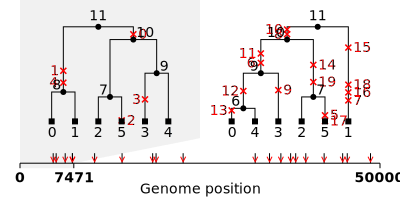

In [6]:
seq_length = 5e4
ts = msprime.sim_ancestry(samples={"SMALL": 1, "BIG": 1, "ADMIX" : 1},
                          demography=demography, random_seed=574,
                         sequence_length=seq_length, recombination_rate=1e-8)
ts = msprime.sim_mutations(ts, rate=1e-7, random_seed=3)
# ts
SVG(ts.draw_svg())

In [7]:
ts_big = msprime.sim_ancestry(samples={"SMALL": 10, "BIG": 10, "ADMIX" : 10},
                          demography=demography, random_seed=574,
                         sequence_length=5e7, recombination_rate=1e-8)
ts_big = msprime.sim_mutations(ts_big, rate=1e-8, random_seed=3)
ts_big

For now, will use a VCF of these.

In [8]:
with open("worksheet5-input.vcf", "w") as vcf_file:
    ts.write_vcf(vcf_file)

### Put data into the right format

Make a SampleData file. Requires:
 - phased genotypes
 - ref and alt allele data
 
First we'll show how to get this info from the VCF file:

In [9]:
a_file = open("worksheet5-input.vcf")

# lines = a_file.readlines()
# for line in lines:
# #     print(line)
# a_file.close()

Note: shouldn't encourage readlines here, because it reads the whole file in all at once.

In [10]:
a_file = open("worksheet5-input.vcf")

lines = a_file.readlines()
with tsinfer.SampleData(sequence_length=seq_length) as sample_data:
    for line in lines:
        if line[0] != "#":
            l = line.split("\t")
#             print(line.split("\t"))
            pos = int(l[1])
            ref = l[3]
            alt = l[4]
#             print(pos, ref, alt)
            gens = "".join(l[9:]).replace("|", "").replace("\n", "")
            gens = [int(g) for g in gens]
#             print(gens)

            sample_data.add_site(pos, gens, [ref, alt])
a_file.close()

Now we have a sample data file.
If you already have a tree sequence file, can use the from_tree_sequence method, as so:

In [11]:
sample_data_big = tsinfer.SampleData.from_tree_sequence(
    ts_big, path="simulation.samples", num_flush_threads=1)

### Using tsinfer

In [12]:
tsi = tsinfer.infer(sample_data, recombination_rate=1e-8)
tsi

Let's have a look at the inferred trees. How do they compare with the real one?

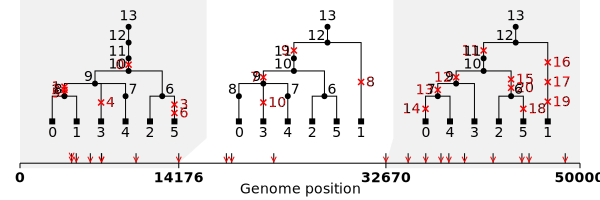

In [13]:
SVG(tsi.draw_svg())

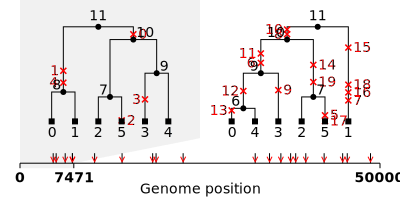

In [14]:
SVG(ts.draw_svg())

Some things to note:
 - Various inaccuracies in topology, and location(s) of recombination breakpoints
 - Some polytomies (see node 9)
 
How might we make sense of this quantitatively?

We'll focus on one way -- looking at genealogical nearest neighbours (GNN).

In [15]:
tsi_big = tsinfer.infer(sample_data_big, recombination_rate=1e-8)

## Genealogical nearest neighbours

Here is a tree from an inferred Plasmodium Vivax sample (Thanks Yan, Wilder).
Tips of tree have been coloured in according to their country of origin.

A useful metric for understanding population level relationships from a tree sequence is genealogical nearest neighbours. Given K sets of reference nodes (e.g., the samples for each of the 15 populations of clonal vivax samples), the GNN statistic for a specific node is a K-vector describing the proportion of its immediate neighbours within the tree from each of these reference sets. Think of this as looking at the most recent node, or ancestor, of each sample and determining what population the other daughter sample(s) of that node came from.

In [16]:
A = tsi.genealogical_nearest_neighbours(
    focal=tsi.samples(), sample_sets=[[0,1], [2, 3], [4, 5]])
A

array([[0.28352   , 0.18494   , 0.53154   ],
       [0.426816  , 0.286592  , 0.286592  ],
       [0.        , 0.        , 1.        ],
       [0.54725333, 0.        , 0.45274667],
       [0.72055333, 0.27944667, 0.        ],
       [0.        , 1.        , 0.        ]])

In [17]:
tsi_big.tables.populations

id,metadata
0,"{'description': '', 'name': 'SMALL'}"
1,"{'description': '', 'name': 'BIG'}"
2,"{'description': '', 'name': 'ADMIX'}"
3,"{'description': '', 'name': 'ANC'}"


First, we'll get the reference sets of samples.

In [18]:
reference_sets = [tsi_big.samples(i) for i in [0, 1, 2]]
reference_sets

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19], dtype=int32),
 array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
        37, 38, 39], dtype=int32),
 array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
        57, 58, 59], dtype=int32)]

We then run the genealogical_nearest_neighbours function, converting the resulting array into a Pandas DataFrame and adding a Population column.

In [19]:
A = tsi_big.genealogical_nearest_neighbours(
    focal=tsi_big.samples(), sample_sets=reference_sets)
gnn = pd.DataFrame(A)
gnn.head()

,0,1,2
0,0.652563,0.00000,0.347437
1,0.704494,0.00027,0.295237
2,0.469977,0.00000,0.530023
3,1.000000,0.00000,0.000000
4,0.458809,0.00000,0.541191


We create a dictionary listing the samples belonging to each population from the metadata.

In [20]:
pop_dict = {}
for p in tsi_big.populations():
    pop_dict[p.metadata['name']] = tsi_big.samples(population=p.id)
pop_dict

{'SMALL': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19], dtype=int32),
 'BIG': array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
        37, 38, 39], dtype=int32),
 'ADMIX': array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
        57, 58, 59], dtype=int32),
 'ANC': array([], dtype=int32)}

In [21]:
pop_names = list(pop_dict.keys())
pop_names

['SMALL', 'BIG', 'ADMIX', 'ANC']

We then use this dictionary to assign a population to each sample and rename the columns by the population they represent.

In [22]:
nodes = tsi_big.tables.nodes
# print(pop_names)
pop_column = []
for s in tsi_big.samples():
    pop_label = nodes[s].population
#     print(pop_label)
    p = pop_names[pop_label]
#     print(pop_names[pop_label])
    pop_column.append(p)

gnn["Population"] = pop_column
gnn.head()

,0,1,2,Population
0,0.652563,0.00000,0.347437,SMALL
1,0.704494,0.00027,0.295237,SMALL
2,0.469977,0.00000,0.530023,SMALL
3,1.000000,0.00000,0.000000,SMALL
4,0.458809,0.00000,0.541191,SMALL


In [23]:
gnn = gnn.rename(index=str, columns={v: k for v, k in enumerate(list(pop_dict.keys()))})
gnn.head()

,SMALL,BIG,ADMIX,Population
0,0.652563,0.00000,0.347437,SMALL
1,0.704494,0.00027,0.295237,SMALL
2,0.469977,0.00000,0.530023,SMALL
3,1.000000,0.00000,0.000000,SMALL
4,0.458809,0.00000,0.541191,SMALL


In [24]:
dfg = gnn.groupby("Population").mean()
dfg = dfg.reindex(sorted(dfg.columns), axis=1)
print(dfg)

               ADMIX       BIG     SMALL
Population                              
ADMIX       0.467321  0.187338  0.345340
BIG         0.181232  0.814067  0.004701
SMALL       0.258030  0.000981  0.740989


<AxesSubplot:ylabel='Population'>

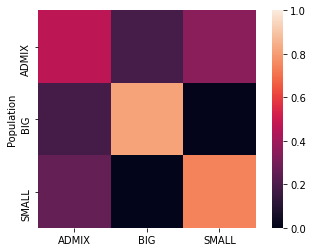

In [25]:
seaborn.heatmap(dfg, vmin=0, vmax=1.0, square=True)

What we don't get from tsinfer: *times*.

In [26]:
tsi.tables.nodes

id,flags,population,individual,time,metadata
0,1,-1,0,0.00000000,b''
1,1,-1,1,0.00000000,b''
2,1,-1,2,0.00000000,b''
3,1,-1,3,0.00000000,b''
4,1,-1,4,0.00000000,b''
5,1,-1,5,0.00000000,b''
6,0,-1,-1,0.33333333,"b'{""ancestor_data_id"": 5}'"
7,0,-1,-1,0.33333333,"b'{""ancestor_data_id"": 6}'"
8,0,-1,-1,0.33333333,"b'{""ancestor_data_id"": 7}'"
9,0,-1,-1,0.50000000,"b'{""ancestor_data_id"": 4}'"


## tsdate

Let's infer some times.

First, apply simplify():

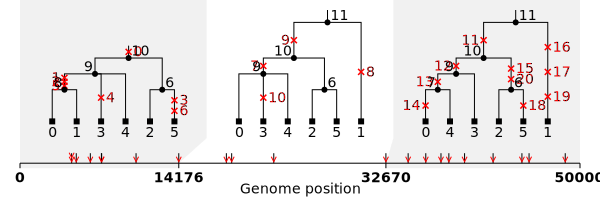

In [27]:
tsi = tsi.simplify()
tsi_big = tsi_big.simplify()
SVG(tsi.draw_svg())

Next, we'll run tsdate:

In [28]:
tsid = tsdate.date(tsi, Ne=500, mutation_rate=1e-8, num_threads=1)

In [29]:
tsid.tables.nodes

id,flags,population,individual,time,metadata
0,1,-1,0,0.00000000,b''
1,1,-1,1,0.00000000,b''
2,1,-1,2,0.00000000,b''
3,1,-1,3,0.00000000,b''
4,1,-1,4,0.00000000,b''
5,1,-1,5,0.00000000,b''
6,0,-1,-1,621.09200808,"b'{""mn"": 621.0920080750495, ""vr"": 128..."
7,0,-1,-1,248.37315423,"b'{""mn"": 248.37315423408768, ""vr"": 37..."
8,0,-1,-1,109.84865447,"b'{""mn"": 109.84865446794741, ""vr"": 89..."
9,0,-1,-1,1204.57695748,"b'{""mn"": 1204.5769574807864, ""vr"": 15..."


Let's also do it for our bigger tree sequence:

In [30]:
tsid_big = tsdate.date(tsi_big, Ne=500, mutation_rate=1e-8, num_threads=1)

Now that we have inferred times and branch lengths, we can apply any of the branch/time related method we saw before -- branch statistics, `ibd_segments` etc -- to get inferred branch statistics, inferred ibd segments and so on.

However! Treat this as an exploratory first pass, and please do continue to use other inferential methods as well.

(Could link to some evidence here about tsdate's performance -- a number of papers have recently come out, plots from my own thesis work).